# Pink Slip Management System - Data Analysis

This notebook analyzes pink slip data to uncover trends

In [79]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

sns.set_style('whitegrid')

# load data from SQLite
conn = sqlite3.connect('instance/pinks.db')

tickets_df = pd.read_sql_query('SELECT * FROM pink_slip', conn)
items_df = pd.read_sql_query('SELECT * FROM pink_slip_item', conn)
conn.close()

# parse dates
tickets_df['date_received'] = pd.to_datetime(tickets_df['date_received'], format='%m/%d/%Y', errors='coerce')
tickets_df['due_date'] = pd.to_datetime(tickets_df['due_date'], format='%m/%d/%Y', errors='coerce')

print(f'Total tickets: {len(tickets_df)}')
print(f'Total items: {len(items_df)}')
print(f'Date range: {tickets_df["date_received"].min().strftime("%m/%d/%Y")} - {tickets_df["date_received"].max().strftime("%m/%d/%Y")}')
print(f'\nTickets preview')
tickets_df.head()

Total tickets: 89992
Total items: 276760
Date range: 01/01/2021 - 12/30/2023

Tickets preview


,id,slip_number,first_initial,last_name,phone,date_received,due_date,due_time,total_amount
0,1,100001,D,Anderson,(980) 555-5719,2021-01-01,2021-01-15,12:00 PM,20.0
1,2,100002,O,Padilla,(704) 555-4683,2021-01-01,2021-01-15,3:00 PM,22.0
2,3,100003,Z,Wagner,(704) 555-4659,2021-01-01,2021-01-15,11:00 AM,9.0
3,4,100004,H,Jensen,(984) 555-4675,2021-01-01,2021-01-15,3:00 PM,9.0
4,5,100005,S,Stephens,(980) 555-6008,2021-01-01,2021-01-15,4:00 PM,25.0


In [80]:
# check the data
print(tickets_df.dtypes)
print()
print(tickets_df.describe())
print()
print(f'Missing values:\n{tickets_df.isnull().sum()}')

id                        int64
slip_number              object
first_initial            object
last_name                object
phone                    object
date_received    datetime64[ns]
due_date         datetime64[ns]
due_time                 object
total_amount            float64
dtype: object

                id                  date_received  \
count  89992.00000                          89992   
mean   44996.50000  2022-06-30 20:06:33.314961152   
min        1.00000            2021-01-01 00:00:00   
25%    22498.75000            2021-09-16 00:00:00   
50%    44996.50000            2022-06-23 00:00:00   
75%    67494.25000            2023-04-17 00:00:00   
max    89992.00000            2023-12-30 00:00:00   
std    25978.59705                            NaN   

                            due_date  total_amount  
count                          89992  89992.000000  
mean   2022-07-14 20:06:33.314961152     25.955852  
min              2021-01-15 00:00:00      3.000000  
25%    

In [81]:
items_df.head(10)

,id,slip_id,item_type,work_description,price
0,1,1,Pants,Take in waist,5.0
1,2,1,Shirt,Resize,15.0
2,3,2,Jeans,Resize,15.0
3,4,2,Coat,Repair,7.0
4,5,3,Pants,Hem,4.0
5,6,3,Shirt,Shorten sleeves,5.0
6,7,4,Pants,Hem,3.0
7,8,4,Pants,Taper,6.0
8,9,5,Jacket,Shorten sleeves,5.0
9,10,5,Jacket,Hem,3.0


## 1. Revenue Analysis

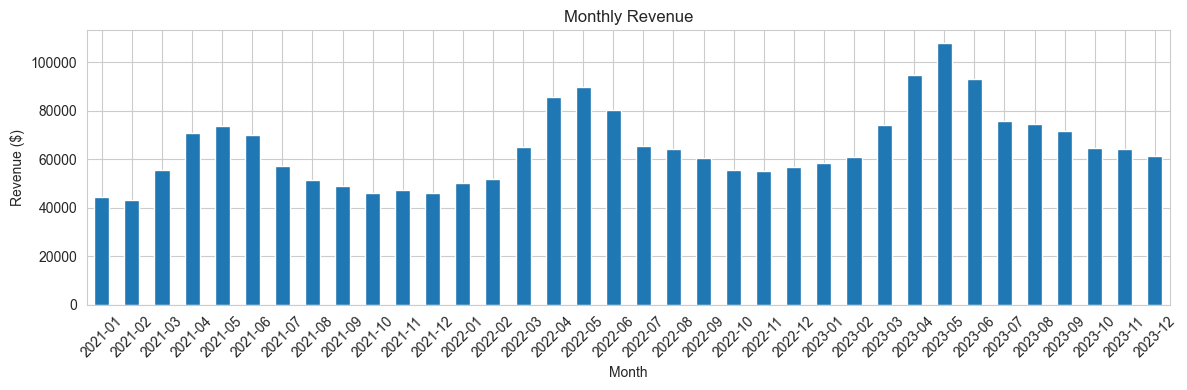

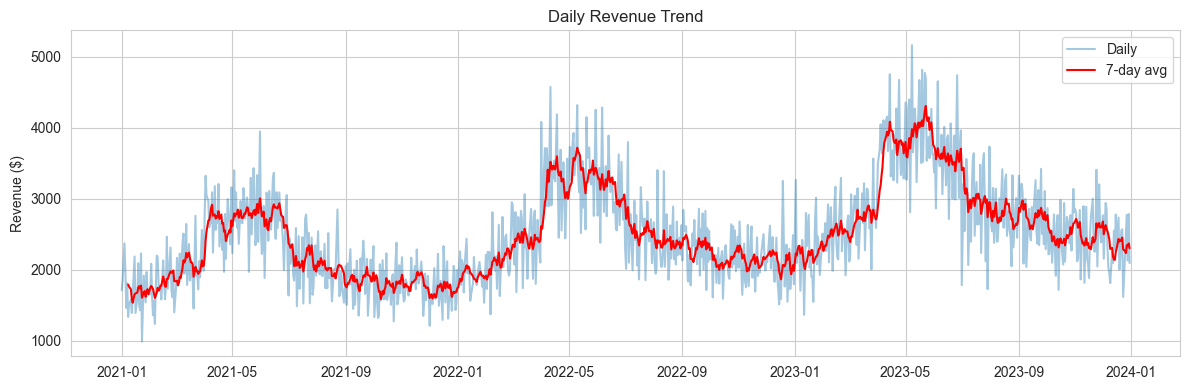

Total revenue: $2,335,819.00
Avg daily revenue: $2,490.21
Avg slip value: $25.96


In [82]:
tickets_df['month'] = tickets_df['date_received'].dt.to_period('M')
monthly_revenue = tickets_df.groupby('month')['total_amount'].sum()

# monthly revenue bar chart
plt.figure(figsize=(12, 4))
monthly_revenue.plot(kind='bar')
plt.title('Monthly Revenue')
plt.ylabel('Revenue ($)')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# daily trend with rolling average
daily_revenue = tickets_df.groupby('date_received')['total_amount'].sum()

plt.figure(figsize=(12, 4))
plt.plot(daily_revenue.index, daily_revenue.values, alpha=0.4, label='Daily')
plt.plot(daily_revenue.index, daily_revenue.rolling(7).mean(), color='red', label='7-day avg')
plt.title('Daily Revenue Trend')
plt.ylabel('Revenue ($)')
plt.legend()
plt.tight_layout()
plt.show()

print(f'Total revenue: ${monthly_revenue.sum():,.2f}')
print(f'Avg daily revenue: ${daily_revenue.mean():,.2f}')
print(f'Avg slip value: ${tickets_df["total_amount"].mean():,.2f}')

## 2. Item Type Frequency

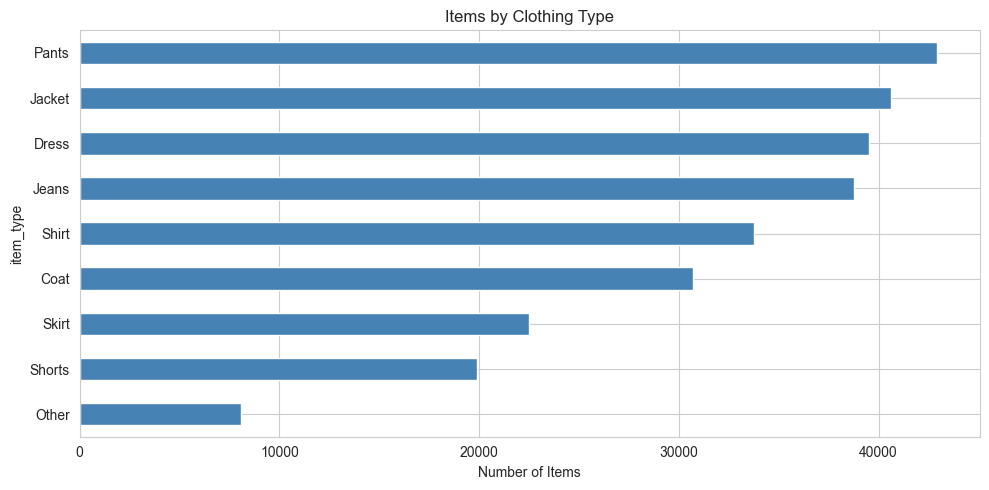

Pants: 42,925 (15.5%)
Jacket: 40,627 (14.7%)
Dress: 39,532 (14.3%)
Jeans: 38,747 (14.0%)
Shirt: 33,736 (12.2%)
Coat: 30,719 (11.1%)
Skirt: 22,493 (8.1%)
Shorts: 19,897 (7.2%)
Other: 8,084 (2.9%)


In [83]:
item_counts = items_df['item_type'].value_counts()

plt.figure(figsize=(10, 5))
item_counts.sort_values().plot(kind='barh', color='steelblue')
plt.xlabel('Number of Items')
plt.title('Items by Clothing Type')
plt.tight_layout()
plt.show()

# breakdown
for item, count in item_counts.items():
    print(f'{item}: {count:,} ({count/len(items_df)*100:.1f}%)')

## 3. Repeat Customer Behavior

Visit frequency per customer - how many times does the average customer come back?

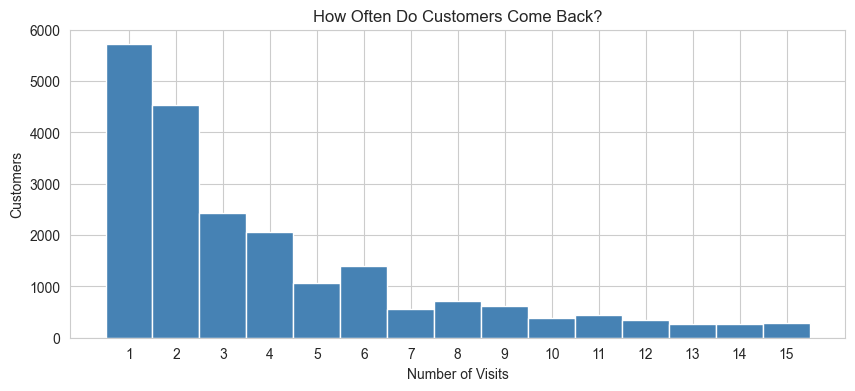

Unique customers: 21,408
Repeat customers (2+ visits): 15,691 (73.3%)
Avg visits per customer: 4.2


In [84]:
# count visits per customer using phone number
customer_visits = tickets_df.groupby('phone').agg(
    visits=('id', 'count'),
    total_spent=('total_amount', 'sum')
).reset_index()

plt.figure(figsize=(10, 4))
max_visits = min(customer_visits['visits'].max(), 15)
plt.hist(customer_visits['visits'], bins=range(1, max_visits + 2),
         color='steelblue', edgecolor='white', align='left')
plt.xlabel('Number of Visits')
plt.ylabel('Customers')
plt.title('How Often Do Customers Come Back?')
plt.xticks(range(1, max_visits + 1))
plt.show()

repeat = len(customer_visits[customer_visits['visits'] > 1])
total = len(customer_visits)
print(f'Unique customers: {total:,}')
print(f'Repeat customers (2+ visits): {repeat:,} ({repeat/total*100:.1f}%)')
print(f'Avg visits per customer: {customer_visits["visits"].mean():.1f}')

## 4. Customer Segmentation

Splitting customers into tiers by how often they visit to see which group brings in the most revenue.

                customers   revenue  pct_customers  pct_revenue
tier                                                           
One-time             5717  143269.0           26.7          6.1
Repeat (2-4)         9023  632277.0           42.1         27.1
Regular (5-10)       4722  854923.0           22.1         36.6
VIP (10+)            1946  705350.0            9.1         30.2



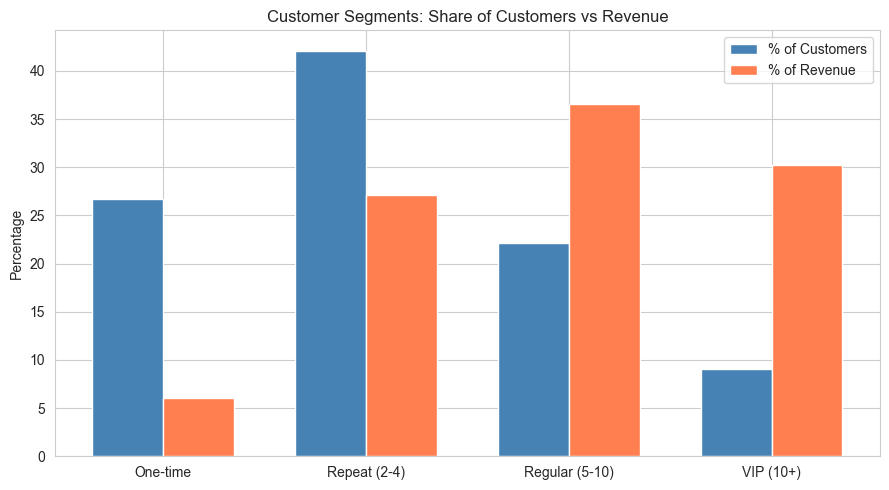

In [85]:
# tier customers by visit count
def get_tier(v):
    if v == 1: return 'One-time'
    if v <= 4: return 'Repeat (2-4)'
    if v <= 10: return 'Regular (5-10)'
    return 'VIP (10+)'

customer_visits['tier'] = customer_visits['visits'].apply(get_tier)

tier_order = ['One-time', 'Repeat (2-4)', 'Regular (5-10)', 'VIP (10+)']
tier_stats = customer_visits.groupby('tier').agg(
    customers=('phone', 'count'),
    revenue=('total_spent', 'sum')
).reindex(tier_order)

tier_stats['pct_customers'] = (tier_stats['customers'] / tier_stats['customers'].sum() * 100).round(1)
tier_stats['pct_revenue'] = (tier_stats['revenue'] / tier_stats['revenue'].sum() * 100).round(1)

print(tier_stats)
print()

# compare what % of customers each tier is vs what % of revenue they bring
fig, ax = plt.subplots(figsize=(9, 5))
x = range(len(tier_order))
w = 0.35
ax.bar([i - w/2 for i in x], tier_stats['pct_customers'], w, label='% of Customers', color='steelblue')
ax.bar([i + w/2 for i in x], tier_stats['pct_revenue'], w, label='% of Revenue', color='coral')
ax.set_xticks(x)
ax.set_xticklabels(tier_order)
ax.set_ylabel('Percentage')
ax.set_title('Customer Segments: Share of Customers vs Revenue')
ax.legend()
plt.tight_layout()
plt.show()

## 5. Seasonal Demand

Looking at order volume by month across all years to see if there's a seasonal pattern.

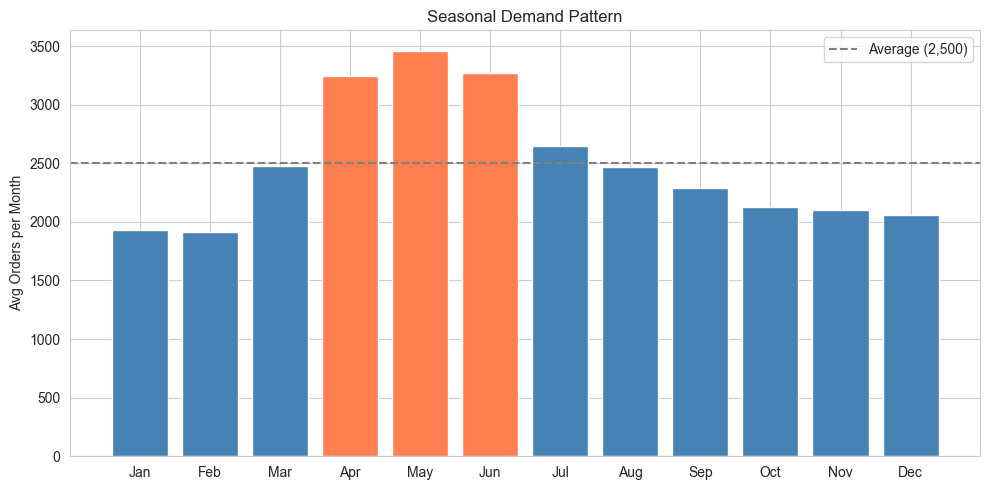

Average monthly orders: 2,500
April-June average: 3,125
Peak season is 25% above average


In [86]:
# average orders per month across all years
tickets_df['month_num'] = tickets_df['date_received'].dt.month
monthly_orders = tickets_df.groupby('month_num').size() / tickets_df['date_received'].dt.year.nunique()

month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
avg_monthly = monthly_orders.mean()

# color april-june differently to highlight peak
colors = ['steelblue' if m not in [4, 5, 6] else 'coral' for m in range(1, 13)]

plt.figure(figsize=(10, 5))
plt.bar(month_labels, monthly_orders.values, color=colors)
plt.axhline(y=avg_monthly, color='gray', linestyle='--', label=f'Average ({avg_monthly:,.0f})')
plt.ylabel('Avg Orders per Month')
plt.title('Seasonal Demand Pattern')
plt.legend()
plt.tight_layout()
plt.show()

# peak months
peak = monthly_orders[4:7].mean()  # apr, may, jun
pct_above = (peak - avg_monthly) / avg_monthly * 100
print(f'Average monthly orders: {avg_monthly:,.0f}')
print(f'April-June average: {peak:,.0f}')
print(f'Peak season is {pct_above:.0f}% above average')

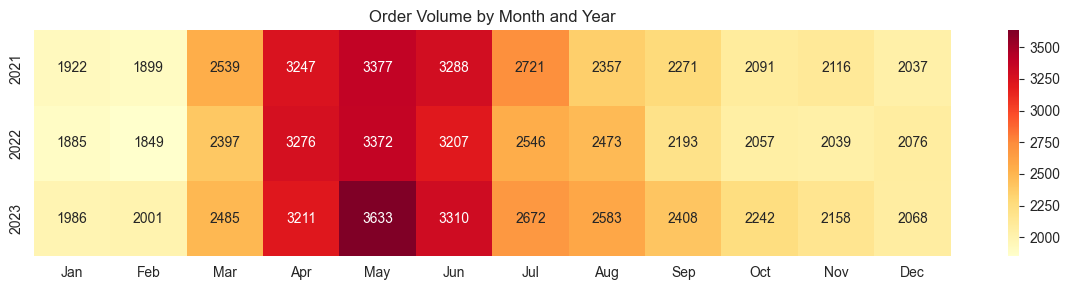

In [87]:
# heatmap of orders by month and year
tickets_df['year'] = tickets_df['date_received'].dt.year
heatmap_data = tickets_df.groupby(['year', 'month_num']).size().unstack(level=1)
heatmap_data.columns = month_labels

plt.figure(figsize=(12, 3))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Order Volume by Month and Year')
plt.ylabel('')
plt.tight_layout()
plt.show()

## Key Findings
- April-June is the busiest season, about 30% more orders than the monthly average
- 73% of customers come back at least once, and repeat customers drive the majority of revenue
- VIP customers (10+ visits) make up less than 10% of the customer base but account for 30% of total revenue
- Average slip value has been growing year over year (around \$22 in 2021, \$27 in 2022, \$30 in 2023)